In [1]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [2]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

In [10]:
data = load_boston()
X_ = data['data']
y_ = data['target']

In [9]:
losses = []

In [11]:
X_.shape

(506, 13)

In [12]:
y_.shape

(506,)

In [19]:
# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [20]:
n_features = X_.shape[1]

In [24]:
n_hidden = 10

In [25]:
W1_ = np.random.randn(n_features, n_hidden)

In [27]:
b1_ = np.zeros(n_hidden)

In [28]:
b1_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
W2_ = np.random.randn(n_hidden, 1)

In [30]:
W2_ 

array([[ 0.87137472],
       [ 1.27089686],
       [ 0.89920761],
       [ 1.31429178],
       [ 0.5111385 ],
       [-0.50091348],
       [ 0.06271697],
       [-0.4437059 ],
       [-0.50247511],
       [-0.56481135]])

In [31]:
b2_ = np.zeros(1)

In [32]:
b2_

array([0.])

In [33]:
# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

In [43]:
X

In [35]:
b1

In [37]:
l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

In [41]:
s1

In [40]:
feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

In [44]:
epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

In [47]:
steps_per_epoch

31

In [54]:
graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

In [49]:
trainables

In [48]:
steps_per_epochgraph

In [50]:
print("Total number of examples = {}".format(m))

Total number of examples = 506


In [55]:
#epochs = 5000
# Step 4 
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, Loss: 125.511
Epoch: 101, Loss: 7.430
Epoch: 201, Loss: 5.465
Epoch: 301, Loss: 5.235
Epoch: 401, Loss: 4.402
Epoch: 501, Loss: 4.131
Epoch: 601, Loss: 3.465
Epoch: 701, Loss: 3.914
Epoch: 801, Loss: 3.408
Epoch: 901, Loss: 3.605
Epoch: 1001, Loss: 3.445
Epoch: 1101, Loss: 3.795
Epoch: 1201, Loss: 3.678
Epoch: 1301, Loss: 3.809
Epoch: 1401, Loss: 3.808
Epoch: 1501, Loss: 3.392
Epoch: 1601, Loss: 3.408
Epoch: 1701, Loss: 3.549
Epoch: 1801, Loss: 3.278
Epoch: 1901, Loss: 2.824
Epoch: 2001, Loss: 3.086
Epoch: 2101, Loss: 2.912
Epoch: 2201, Loss: 3.297
Epoch: 2301, Loss: 3.117
Epoch: 2401, Loss: 2.795
Epoch: 2501, Loss: 3.268
Epoch: 2601, Loss: 3.640
Epoch: 2701, Loss: 3.202
Epoch: 2801, Loss: 3.435
Epoch: 2901, Loss: 3.092
Epoch: 3001, Loss: 3.268
Epoch: 3101, Loss: 3.289
Epoch: 3201, Loss: 3.248
Epoch: 3301, Loss: 2.981
Epoch: 3401, Loss: 3.082
Epoch: 3501, Loss: 3.488
Epoch: 3601, Loss: 3.171
Epoch: 3701, Loss: 3.196
Epoch: 3801, Loss: 3.154
Epoch: 3901, Loss: 3.486
Epoch: 400

In [56]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [57]:
forward(l2,graph)

array([[13.62958359],
       [18.7454675 ],
       [25.51092155],
       [49.71183786],
       [23.98830506],
       [16.636096  ],
       [31.20236199],
       [37.28424709],
       [47.38272986],
       [21.50917432],
       [10.07446396],
       [16.27074471],
       [37.28424709],
       [21.47535696],
       [23.37936425],
       [19.83178643]])

In [58]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)

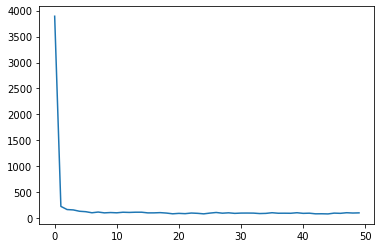

In [60]:
plt.plot(range(len(losses)), losses)

In [61]:
W2.value

array([[ 9.09450617],
       [12.38010493],
       [ 7.33662176],
       [ 6.84320628],
       [ 9.79426189],
       [ 3.76614756],
       [ 6.42520638],
       [ 7.3566733 ],
       [ 4.84063666],
       [ 6.61528199]])

In [62]:
X_ = data['data']

In [63]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])